In [25]:
import numpy as np
import imageio
import os, time
import matplotlib.pyplot as plt
from scipy import signal, sparse

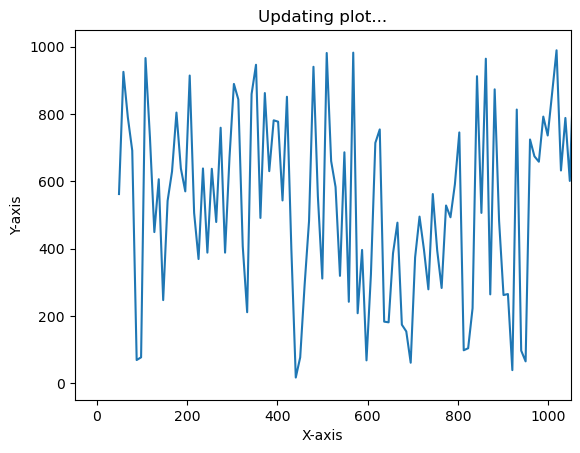

In [24]:

 
# generating random data values
x = np.linspace(1, 1000, 5000)
y = np.random.randint(1, 1000, 5000)
 
# enable interactive mode
plt.ion()
 
# creating subplot and figure
fig = plt.figure()
ax = fig.add_subplot(111)
line1, = ax.plot(x, y)
 
# setting labels
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title("Updating plot...")
 
# looping
for _ in range(50):
   
    # updating the value of x and y
    line1.set_xdata(x*_)
    line1.set_ydata(y)
 
    # re-drawing the figure
    fig.canvas.draw()
     
    # to flush the GUI events
    fig.canvas.flush_events()
    time.sleep(0.1)

In [26]:
img_clean = 'C:/Users/phmin/Desktop/Blind Deconvolution/fastdeconv/online_code/Levin09_im08_filt04_orig.tif'
img_noisy = 'C:/Users/phmin/Desktop/Blind Deconvolution/fastdeconv/online_code/Levin09_im08_filt04_blurry.tif'
Xc = imageio.v2.imread(img_clean)
Yb = imageio.v2.imread(img_noisy)

Xc.astype('float')
Yb.astype('float')

Xc = Xc/ np.max(Xc)
Yb = Yb/ np.max(Yb)


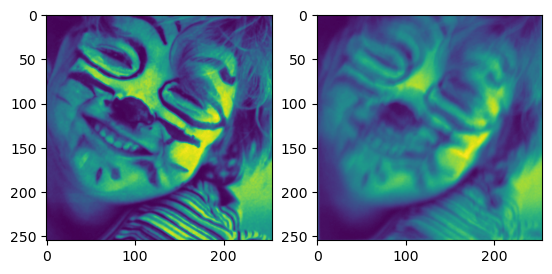

In [27]:
plt.subplot(121)
plt.imshow(Xc);
plt.subplot(122)
plt.imshow(Yb);

In [46]:
k_size=31;
padsz = k_size//2
b0 = Yb[padsz:-padsz, padsz:-padsz]*0.6 + 0.2

X0 = np.copy(Xc);

ld=0
ker0 = np.zeros((k_size,k_size))
ker0[padsz-1:padsz+3,padsz-1:padsz+3]=1
ker0 = ker0/np.sum(ker0)

c=0.1

ker = np.copy(ker0)
w_l1 = ld / np.maximum( 0.0001, np.abs(ker))
print('w_l1 shape=',w_l1.shape)

# ||Xk + c1 - b||^2
# XtX_k + Xtv1_c = Xtb
# v1X_k + v1v1_c = v1b

M,N = b0.shape
Ones = np.ones((M,N))

Xt = np.rot90(X0, 2)
#plt.imshow(flipX)
Xtb = signal.convolve2d(Xt, b0, mode='valid')
print('RHS shape = ',X0.shape)

#compute XtX_k & Xtv1_c
X_k = signal.convolve2d(X0,ker, mode='valid')
XtX_k = signal.convolve2d(Xt,X_k, mode='valid')
#XtX_k = XtX_k + w_l1*ker

Xtv1   = signal.convolve2d(Xt,Ones, mode='valid')
Xtv1_c = c*Xtv1 

r1 = Xtb - XtX_k - Xtv1_c

#compute v1X_k & v1v1_c
v1X_k = signal.convolve2d(Ones,X_k, mode='valid')
v1v1  = signal.convolve2d(Ones,Ones, mode='valid')
v1b = signal.convolve2d(Ones,b0, mode='valid')

r2 = v1b - v1X_k - v1v1*c


# conjugate gradient descent
for iter in range(30):
    rho = np.linalg.norm(r1,ord='fro')**2 + r2*r2
    if iter>0:
        beta = rho/rho_1
        p1 = r1 + beta*p1
        p2 = r2 + beta*p2
    else:
        p1 = r1
        p2 = r2
    #end if
    
    #compute XtX_p + Xtv1_p
    X_p   = signal.convolve2d(X0,p1, mode='valid')
    XtX_p = signal.convolve2d(Xt,X_p, mode='valid')
    #XtpX += w_l1*p
    Xtv1_p  = Xtv1*p2
    q1 = XtX_p + Xtv1_p
    
    #compute v1X_p + v1v1_p
    #v1X_p  = signal.convolve2d(Ones,X_p, mode='valid')
    v1X_p  = np.sum(Ones*X_p)
    v1v1_p = v1v1*p2
    q2 = v1X_p + v1v1_p
    
    alpha = rho / ( np.sum(p1*q1) + p2*q2 )
    ker = ker + alpha * p1
    c   = c   + alpha * p2
    
    r1  = r1  - alpha * q1
    r2  = r2  - alpha * q2
    rho_1 = rho
    
    if iter%10==9:
        X_k = signal.convolve2d(X0,ker, mode='valid')
        print(iter+1,'. error=', np.linalg.norm(X_k +c - b0,ord='fro') / np.linalg.norm(b0,ord='fro') )
    #end
#

w_l1 shape= (31, 31)
RHS shape =  (255, 255)
10 . error= 0.044922143685635796
20 . error= 0.01546507223551504
30 . error= 0.009300256007328986


c =  [[0.20066277]]


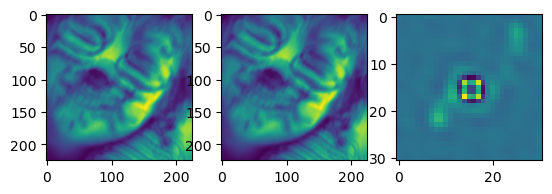

In [40]:
print('c = ',c)
plt.subplot(1,3,1)
plt.imshow(b0)
plt.subplot(1,3,2)
plt.imshow( signal.convolve2d(X0,ker, mode='valid')+c )
plt.subplot(1,3,3)
plt.imshow(ker)

In [74]:
aa = np.array([[3,4],[2,5]])
bb = np.array([[1,1],[2,2]])
print(np.linalg.norm(aa,ord='fro')**2)
print(np.sum(aa*bb))

54.0
21
